### Import Libraries

In [1]:
from opinion import Opinion
from binomialoperators import BinomialOperators
from complex_operators import ComplexOperators
from decimal import *
binop = BinomialOperators()
import pandas as pd

### Cumulative Belief Fusion
Get Primary and Dispatch Diagnosis equivalence

In [2]:
fields=['Call Number/Patient Number', 'DspProbCodeDescription', 'PrimaryProbDescription', 'SecondaryProbDescription']
data = pd.read_csv("EWEMSDataExport.csv", skipinitialspace=True, usecols=fields)
given_notgiven = {}
for index, row in data.iterrows():
    if row['PrimaryProbDescription'] not in given_notgiven:
        given_notgiven[row['PrimaryProbDescription']] = [0, 0]
    if row['PrimaryProbDescription'] == row['DspProbCodeDescription']:
        given_notgiven[row['PrimaryProbDescription']][0] += 1
    else:
        given_notgiven[row['PrimaryProbDescription']][1] += 1

In [3]:
given_notgiven_df = pd.DataFrame.from_dict(given_notgiven, orient='index', columns=['correctdsptch', 'wrongdsptch'])
given_notgiven_df.to_csv('primary_given.csv')

In [4]:
primaryopinions = []
W = 2
a = 0.5
for index, row in given_notgiven_df.iterrows():
    r = row['correctdsptch']
    s = row['wrongdsptch']
    t = s + r
    if (r !=0 and s!=0):
        b = r / (W + t)
        d = s / (W + t)
        u = 2 / (W + t)
        primaryopinions.append(Opinion(belief=b, disbelief=d, baserate=a))

In [5]:
comp = ComplexOperators()
cf = primaryopinions[0]
beliefs = []
disbeliefs = []
uncertainties = []
beliefs.append(cf.b)
disbeliefs.append(cf.d)
uncertainties.append(cf.u)
for y in primaryopinions[1:]:
    cf = comp.cumulativefusion(cf, y)
    beliefs.append(cf.b)
    disbeliefs.append(cf.d)
    uncertainties.append(cf.u)
uncertainties[0]

0.0002148458481040505

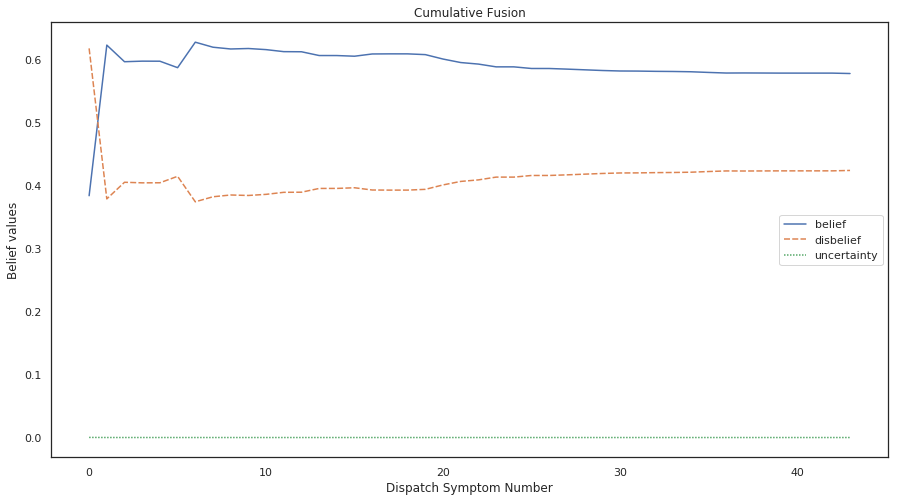

In [15]:
import numpy as np
import altair as alt
alt.renderers.enable('notebook')
belief_df = pd.DataFrame({'belief': beliefs, 'disbelief': disbeliefs, 'uncertainty': uncertainties})
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(15,8))
plt.xlabel('Dispatch Symptom Number')
plt.ylabel('Belief values')
plt.title('Cumulative Fusion')
sns.set(style="white")
ax = sns.lineplot(data=belief_df)
ax

### Deduction

y = Dispatch Diagnosis correct

x = Primary Diagnosis correct

y | x = Dispatch Diagnosis is correct when Primary Diagnosis is correct

y | notx = Dispatch Diagnosis is correct when Primary Diagnosis is wrong

In [7]:
all3fields_df = pd.read_csv('all3fields.csv')
all3fields_df.sample(5)

,Code,Dispatch,Primary,Secondary
1682,9167347,Resp. Distress,Resp. Distress,Confusion/Disorientation
1026,9118638,Ischemic Chest Pain,Ischemic Chest Pain,Resp. Distress
669,9057352,Stroke/TIA,Headache,Confusion/Disorientation
725,9063419,Abdominal Pain NYD,Abdominal Pain NYD,General Illness/Weakness
372,9101198,Resp. Distress,Other Medical/Trauma,GI Problems/Pain/Vomiting/Nausea


In [8]:
ygivenx = {'r': 0, 's': 0}
ygivennotx = {'r': 0, 's': 0}
x = {'r': 0, 's': 0}
for index, row in all3fields_df.iterrows():
    if(row["Primary"] == row["Secondary"]):
        if(row["Dispatch"] == row["Primary"]):
            ygivenx['r'] += 1
        else:
            ygivenx['s'] += 1
        x['r'] += 1
    else:
        if(row["Dispatch"] == row["Primary"]):
            ygivennotx['r'] += 1
        else:
            ygivennotx['s'] += 1
        x['s'] += 1
ygivenx, ygivennotx, x

({'r': 16, 's': 20}, {'r': 888, 's': 892}, {'r': 36, 's': 1780})

In [9]:
#y given x opinion calc
b = ygivenx['r'] / (2 + ygivenx['r'] + ygivenx['s'])
d = ygivenx['s'] / (2 + ygivenx['r'] + ygivenx['s'])
u = 2 / (2 + ygivenx['r'] + ygivenx['s'])
a = 1 / 3
ygivenx_opinion = Opinion(belief=b, disbelief=d, uncertainty=u, baserate=a)
print(ygivenx_opinion)

b: 0.42, d: 0.53, u: 0.05, a: 0.33, p: 0.44


In [10]:
#y given not x opinion calc
b = ygivennotx['r'] / (2 + ygivennotx['r'] + ygivennotx['s'])
d = ygivennotx['s'] / (2 + ygivennotx['r'] + ygivennotx['s'])
u = 2 / (2 + ygivennotx['r'] + ygivennotx['s'])
a = 1 / 3
ygivennotx_opinion = Opinion(belief=b, disbelief=d, uncertainty=u, baserate=a)
print(ygivennotx_opinion)

b: 0.50, d: 0.50, u: 0.00, a: 0.33, p: 0.50


In [11]:
#x opinion calc
b = x['r'] / (2 + x['r'] + x['s'])
d = x['s'] / (2 + x['r'] + x['s'])
u = 2 / (2 + x['r'] + x['s'])
a = 1 / 3
x_opinion = Opinion(belief=b, disbelief=d, uncertainty=u, baserate=a)
print(x_opinion)

b: 0.02, d: 0.98, u: 0.00, a: 0.33, p: 0.02


In [12]:
print("Deduction: ", comp.deduction(ygivenx_opinion, ygivennotx_opinion, x_opinion))

Deduction:  b: 0.50, d: 0.50, u: 0.00, a: 0.33, p: 0.50


### Abduction

In [13]:
y = {'r': 0, 's': 0}
for index, row in all3fields_df.iterrows():
    if(row["Dispatch"] == row["Primary"]):
        y['r'] += 1
    else:
        y['s'] += 1
b = y['r'] / (2 + y['r'] + y['s'])
d = y['s'] / (2 + y['r'] + y['s'])
u = 2 / (2 + y['r'] + y['s'])
a = 1 / 3
y_opinion = Opinion(belief=b, disbelief=d, uncertainty=u, baserate=a)
print(y_opinion)

b: 0.50, d: 0.50, u: 0.00, a: 0.33, p: 0.50


In [14]:
print("Abduction: ", comp.abduction(ygivenx_opinion, ygivennotx_opinion, y_opinion))

Abduction:  b: 0.03, d: 0.08, u: 0.89, a: 0.30, p: 0.30
